# Model Deployment Class, replicating

In [10]:
from helper_functions import accuracy_fn, download_data, plot_decision_boundary, plot_loss_curves, plot_predictions, set_seeds
# from helper_functions import download_data, set_seeds, plot_loss_curves
from going_modular import engine, data_loaders
from going_modular import predictions
from going_modular.engine import train_step, test_step
from going_modular.utils import save_model
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import requests
import sklearn
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets

from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
writer = SummaryWriter()
import zipfile



In [11]:
# see torch and torch vision plus
print (torch.__version__)
print (torchvision.__version__)

2.3.0
0.18.0


In [12]:
# !nvcc --version

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def set_seeds (seed: int=42):
    """_summary_

    Args:
        seed (int, optional): _description_. Defaults to 42.
    """ 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)   

In [14]:
import torch
torch.cuda.is_available()

True

In [15]:
# wet up data paths
# E:\Dropbox\GithubRepo\Udemy\pytorch-deep-learning-main\pytorch-deep-learning-main - Copy\data\pizza_steak_sushi_20_percent
data_20_percent_path = Path('../data/pizza_steak_sushi_20_percent')
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
print (f'effnetb2 transforms: {effnetb2_transforms}')
# effnetb2 = torchvision.models.efficientnet_b2(weights="effnetb2_weights")
effnetb2 = torchvision.models.efficientnet_b2(weights="DEFAULT")

for param in effnetb2.parameters():
    param.requires_grad=False


effnetb2 transforms: ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [16]:
from torchinfo import summary
# effnetb2
summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [17]:
# get input size of last layer
effnetb2_lastlayer = list(effnetb2.children())[-1]
effnetb2_last_child_layer_inpu_count = list(effnetb2_lastlayer.children())[-1].in_features
effnetb2_last_child_layer_inpu_count

1408

In [18]:
set_seeds()
effnetb2.classifier=nn.Sequential(
    nn.Dropout(p = 0.3, inplace=True),
    nn.Linear(in_features=effnetb2_last_child_layer_inpu_count, out_features=3)

)

In [19]:
# function to create effnetb2
def create_effnetb2(output_feature_count:int, drop_out = 0.3, seed:int=42)-> nn.Module:
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms= weights.transforms()
    model = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    last_layer = list(model.children())[-1]
    last_child_layer = list(last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.classifer = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features =last_input, 
                  out_features = output_feature_count).to(device))

    model.name = 'effnetb2'
    print (f'[INFO] created new {model.name} model')
    
    return model, transforms




In [24]:
effnetb2, effnetb2_transforms = create_effnetb2(output_feature_count=3)
effnetb2
print(summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

effnetb2_transforms

[INFO] created new effnetb2 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            4,227                Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [25]:
# data loader
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_loaders.create_dataloaders(train_dir=train_dir, 
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=effnetb2_transforms, 
                                                                                          batch_size=32)

In [26]:
len (train_dataloader_effnetb2), len (test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [27]:
loss_fn = nn.CrossEntropyLoss()
effnetb2_optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)

In [28]:
# general trainer

def train (model: torch.nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           optimizer: torch.optim.Optimizer,
           loss_fn: torch.nn.Module,
           epochs: int,
           device: torch.device,
           writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    
    results = {'train_loss':[],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer,
                                           device = device)
        
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        device=device)
        
        print (
            f'Epoch: {epoch + 1} |'
            f'train_loss: {train_loss:.4f} |'
            f'train_acc: {train_acc:.4f} |'
            f'test_loss {test_loss:.4f} |'
            f'test_acc:  {test_acc}:.4f'

        )

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    if writer:
        writer.add_scalars (main_tag = 'Accuracy',
                            tag_scalar_dict = {'train_acc': train_acc,
                                              'test_acc':test_acc},
                            global_step=epoch)
        writer.add_scalars (main_tag = 'Loss',
                           tag_scalar_dict = {'train_loss': train_loss,
                                              'test_loss' : test_loss},
                            global_step = epoch)
        
        writer.add_graph (model = model,
                          input_to_model = torch.randn(32, 3, 224, 224).to(device))# 3 or 1?
    
    writer.close()

    return results

In [29]:
# train effnetb2
set_seeds()

effnetb2_retults = train (model = effnetb2,
                          train_dataloader=train_dataloader_effnetb2,
                          test_dataloader=test_dataloader_effnetb2,
                          optimizer=effnetb2_optimizer,
                          loss_fn = loss_fn,
                          epochs = 10,
                          device=device,
                          writer=writer)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Tiger\anaconda3\envs\Py311UdemyWCUDA1\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
 10%|█         | 1/10 [00:06<00:55,  6.20s/it]

Epoch: 1 |train_loss: 5.6083 |train_acc: 0.0521 |test_loss 4.4443 |test_acc:  0.11136363636363637:.4f


 20%|██        | 2/10 [00:11<00:46,  5.79s/it]

Epoch: 2 |train_loss: 2.6015 |train_acc: 0.2938 |test_loss 2.5143 |test_acc:  0.40625:.4f


 30%|███       | 3/10 [00:17<00:39,  5.61s/it]

Epoch: 3 |train_loss: 1.7577 |train_acc: 0.4021 |test_loss 1.9555 |test_acc:  0.5022727272727272:.4f


 40%|████      | 4/10 [00:22<00:33,  5.53s/it]

Epoch: 4 |train_loss: 1.3481 |train_acc: 0.5437 |test_loss 1.4986 |test_acc:  0.6113636363636363:.4f


 50%|█████     | 5/10 [00:28<00:27,  5.55s/it]

Epoch: 5 |train_loss: 1.1635 |train_acc: 0.6125 |test_loss 1.2636 |test_acc:  0.7426136363636363:.4f


 60%|██████    | 6/10 [00:33<00:22,  5.63s/it]

Epoch: 6 |train_loss: 1.0083 |train_acc: 0.6542 |test_loss 1.1964 |test_acc:  0.7732954545454545:.4f


 70%|███████   | 7/10 [00:39<00:16,  5.60s/it]

Epoch: 7 |train_loss: 0.8888 |train_acc: 0.7188 |test_loss 1.0272 |test_acc:  0.8039772727272727:.4f


 80%|████████  | 8/10 [00:44<00:11,  5.52s/it]

Epoch: 8 |train_loss: 0.7835 |train_acc: 0.7708 |test_loss 1.0141 |test_acc:  0.7863636363636364:.4f


 90%|█████████ | 9/10 [00:49<00:05,  5.41s/it]

Epoch: 9 |train_loss: 0.7133 |train_acc: 0.8000 |test_loss 0.8992 |test_acc:  0.8204545454545455:.4f


100%|██████████| 10/10 [00:55<00:00,  5.51s/it]

Epoch: 10 |train_loss: 0.7089 |train_acc: 0.8125 |test_loss 0.7244 |test_acc:  0.8727272727272727:.4f


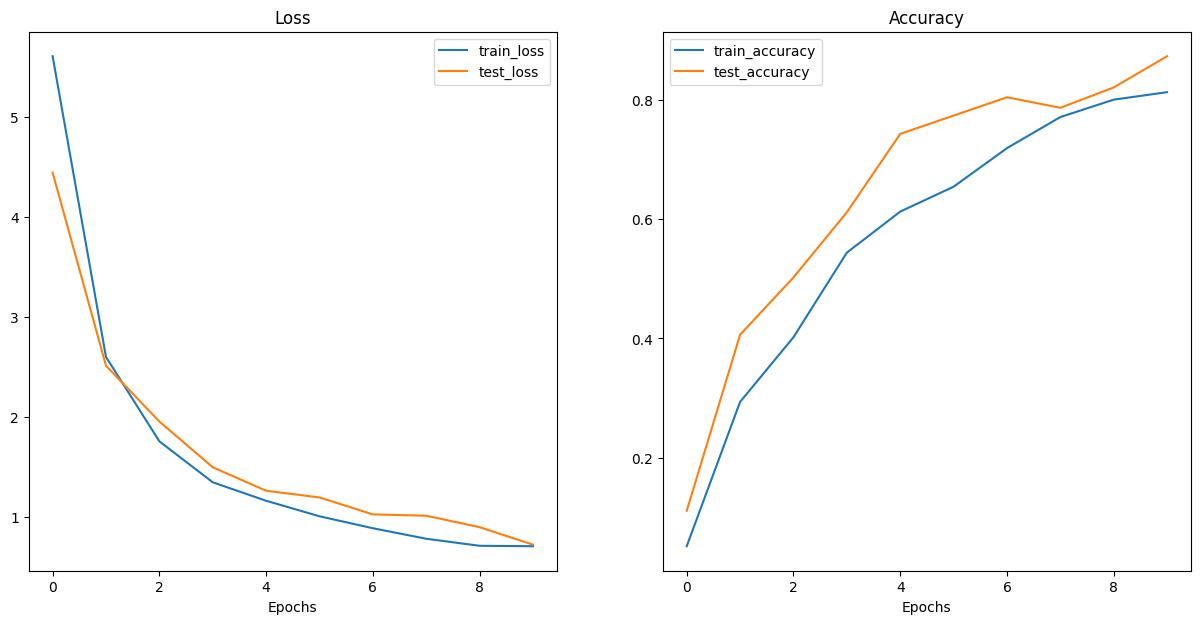

In [32]:
# !nvidia-smi
plot_loss_curves(effnetb2_retults)

### 3.5 Save the EffNetB2 feeature extractor

In [34]:
model_path = f"09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth"
save_model (model = effnetb2,
            target_dir="models",
            model_name = model_path)

[INFO] Saving model to: models\09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_10_epochs.pth


### 3.6 inspect size of EFFNetB2

In [46]:
pretrained_effnetb2_model_size = Path("models/", model_path).stat().st_size/(1024 * 1024)

### 3.7 Colling EffNetB2 feature extractor stats

In [49]:
# count number of paramters
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

9114221

In [51]:
effnetb2_stats = {'test_loss':effnetb2_retults['test_loss'][-1],
                  'test_acc':effnetb2_retults['test_acc'][-1],
                  'number_of_paramters': effnetb2_total_params,
                  'model_size (MB)': pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.7244044423103333,
 'test_acc': 0.8727272727272727,
 'number_of_paramters': 9114221,
 'model_size (MB)': 35.26795196533203}

## 4.0 ViT feature extractor

In [ ]:
vit = torchvision.models.vit_b_16()
vit.heads

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [63]:
# list(list(vit.children())[-1])[-1].in_features

768

In [72]:
# create vit model
def create_vit_model(num_classes: int = 3, drop_out = 0.3, seed:int=42)-> nn.Module:
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    model= torchvision.models.vit_b_16(weights=weights).to(device)
    transforms=weights.transforms()

    for param in model.parameters():
        param.requires_grad = False

    set_seeds(seed=seed)

    last_layer = list (model.children())[-1]
    last_child_layer = list (last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.heads = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features=last_input,
                  out_features=num_classes).to(device))
    
    model.name = 'ViT_B_16'
    print (f'[INFO] created new {model.name} model')

    return model, transforms

In [74]:
vit, vit_transforms = create_vit_model(num_classes=3)

print(summary(model=vit,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

vit_transforms

[INFO] created new ViT_B_16 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)           

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2(output_feature_count=3)
effnetb2
print(summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

effnetb2_transforms

[INFO] created new effnetb2 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            4,227                Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 4.1 ViT Dataloader

In [75]:
# data loader
train_dataloader_vit, test_dataloader_vit, class_names = data_loaders.create_dataloaders(train_dir=train_dir, 
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=vit_transforms, 
                                                                                          batch_size=32)

### 4.2 Vit training

In [78]:
loss_fn = nn.CrossEntropyLoss()
vit_optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)

In [79]:
# train vit
set_seeds()

vit_retults = train (model = vit,
                          train_dataloader=train_dataloader_vit,
                          test_dataloader=test_dataloader_vit,
                          optimizer=vit_optimizer,
                          loss_fn = loss_fn,
                          epochs = 10,
                          device=device,
                          writer=writer)

 10%|█         | 1/10 [00:11<01:46, 11.79s/it]

Epoch: 1 |train_loss: 0.7245 |train_acc: 0.7250 |test_loss 0.2896 |test_acc:  0.9289772727272727:.4f


 20%|██        | 2/10 [00:18<01:08,  8.57s/it]

Epoch: 2 |train_loss: 0.2648 |train_acc: 0.9083 |test_loss 0.1720 |test_acc:  0.9602272727272727:.4f


 30%|███       | 3/10 [00:24<00:52,  7.54s/it]

Epoch: 3 |train_loss: 0.1975 |train_acc: 0.9479 |test_loss 0.1281 |test_acc:  0.9693181818181819:.4f


 40%|████      | 4/10 [00:30<00:42,  7.05s/it]

Epoch: 4 |train_loss: 0.1410 |train_acc: 0.9604 |test_loss 0.1085 |test_acc:  0.972159090909091:.4f


 50%|█████     | 5/10 [00:37<00:33,  6.79s/it]

Epoch: 5 |train_loss: 0.1234 |train_acc: 0.9646 |test_loss 0.0965 |test_acc:  0.978409090909091:.4f


 60%|██████    | 6/10 [00:43<00:26,  6.64s/it]

Epoch: 6 |train_loss: 0.1387 |train_acc: 0.9354 |test_loss 0.0846 |test_acc:  0.972159090909091:.4f


 70%|███████   | 7/10 [00:49<00:19,  6.52s/it]

Epoch: 7 |train_loss: 0.1079 |train_acc: 0.9625 |test_loss 0.0831 |test_acc:  0.9875:.4f


 80%|████████  | 8/10 [00:56<00:13,  6.51s/it]

Epoch: 8 |train_loss: 0.1237 |train_acc: 0.9437 |test_loss 0.0761 |test_acc:  0.978409090909091:.4f


 90%|█████████ | 9/10 [01:02<00:06,  6.46s/it]

Epoch: 9 |train_loss: 0.1052 |train_acc: 0.9771 |test_loss 0.0750 |test_acc:  0.978409090909091:.4f


100%|██████████| 10/10 [01:08<00:00,  6.89s/it]

Epoch: 10 |train_loss: 0.0786 |train_acc: 0.9854 |test_loss 0.0640 |test_acc:  1.0:.4f



c:\Users\Tiger\anaconda3\envs\Py311UdemyWCUDA1\Lib\site-packages\torch\__init__.py:1559: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


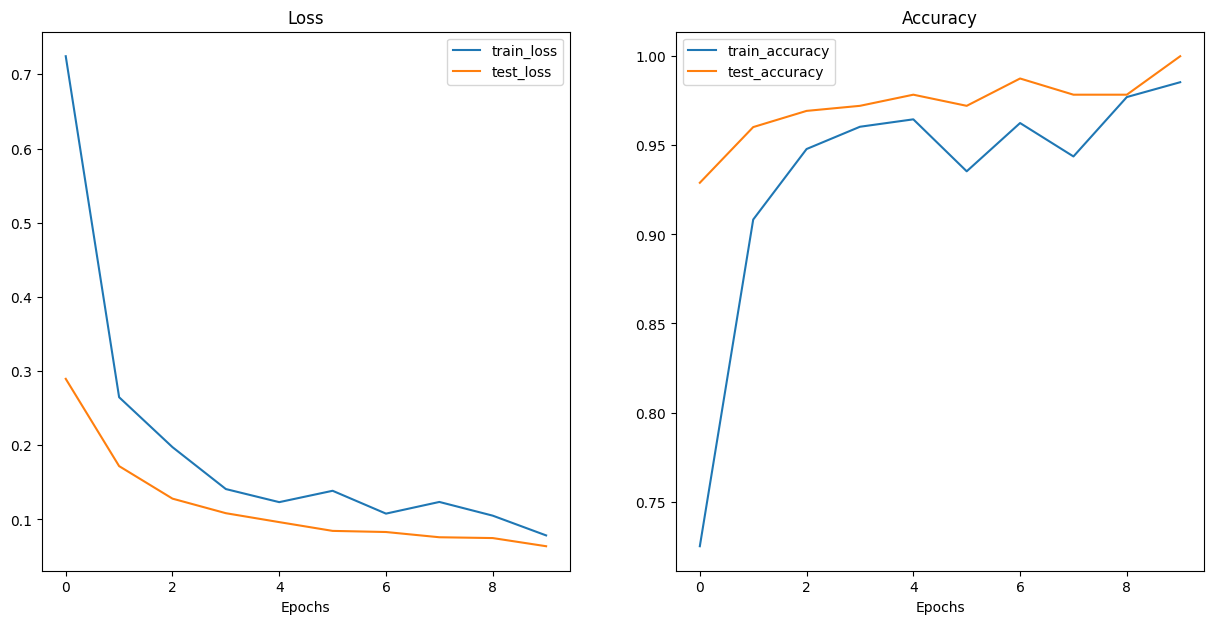

In [81]:
# train effnetb2
plot_loss_curves(vit_retults)

### 4.3 Save the fit feeature extractor

In [82]:
vit_model_path = f"09_pre_trained_vit_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth"
save_model (model = vit,
            target_dir="models",
            model_name = vit_model_path)

[INFO] Saving model to: models\09_pre_trained_vit_feature_extractor_pizza_steak_sushi_20_percent_10_epochs.pth


### 4.4 inspect size of vit

In [83]:
pretrained_vit_model_size = Path("models/", vit_model_path).stat().st_size/(1024 * 1024)
pretrained_vit_model_size

327.38194465637207

### 4.6 Collecting vit feature extractor stats

In [85]:
# count number of paramters
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [86]:
vit_stats = {'test_loss':vit_retults['test_loss'][-1],
                  'test_acc':vit_retults['test_acc'][-1],
                  'number_of_paramters': vit_total_params,
                  'model_size (MB)': pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06396642997860909,
 'test_acc': 1.0,
 'number_of_paramters': 85800963,
 'model_size (MB)': 327.38194465637207}

## 5. Making Prediction swith our trained data models
